- competition/dataset : [https://www.kaggle.com/mlg-ulb/creditcardfraud](https://www.kaggle.com/mlg-ulb/creditcardfraud)
- date : 2021/03/31
- original : [https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now](https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now)

## Classifying multi-label comments (0.9741 lb)

**✏ 필사 1회** 

이 노트북은 편향된 데이터에 다양한 방법들을 테스트합니다. 우리의 예측 모델의 효율을 방해할 수 있는 압도적으로 다수인 클래스가 있을 때 전처리 기술이 더 잘 작동하는지를 비교하는 것이 한 가지 아이디어입니다.  

또한 다양한 분류 모델에서 하이퍼파라미터 튜닝에 교차 검증을 적용하는 방법을 볼 수 있습니다. 제 의도는 다음의 모델들을 사용하여 모델을 만드는 것입니다:  
1. Logistic Regression
2. SVMs
3. Decision trees

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

### Loading the dataset

In [2]:
data = pd.read_csv('data/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Checking the target classes

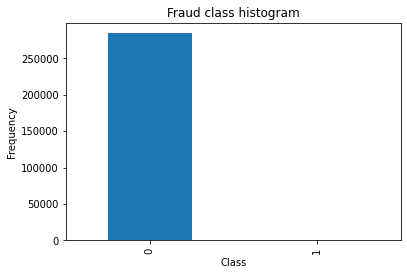

In [3]:
count_classes = data.value_counts('Class', sort=True)
count_classes.plot(kind='bar')
plt.title('Fraud class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

확실히 데이터가 완전히 불균형합니다.  

이것은 분류 알고리즘을 평가하기 위해 일반적인 정확도 점수를 사용하는 명확한 예시입니다. 예를 들어, 우리가 다수 클래스를 사용하여 모든 레코드에 값을 할당했다면 여전히 높은 정확도를 얻을 수는 있지만 우리는 모든 1을 잘못 분류하고 있을 것입니다.  

이러한 불균형을 고려하여 분류 문제에 접근하기 위한 몇 가지 방법들이 있습니다:  
- 더 많은 데이터 수집  
    - 좋은 전략이지만 여기서는 적용 불가  
- 평가 메트릭 변경  
    - 정밀도와 재현율을 계산하기 위해 혼동 행렬 사용  
    - F1 score
    - Kappa 사용 - 데이터의 클래스 불균형에 의해 정규화된 분류 정확도
    - ROC curve - 민감도(Sensitivity)/특이도(Specificity) 비율 계산  
- 데이터 리샘플링  
    - 데이터가 50:50 정도의 비율이 되도록 하는 방법  
    - OVER-sampling - 수가 적은 클래스의 복사본을 추가 (데이터 수가 적을 때 추천)  
    - UNDER-sampling - 수가 많은 클래스로부터 인스턴스를 제거 (데이터 수가 많을 때 추천)

### Approach
1. 우선은 feature engineering을 수행하지 않습니다.  
2. resampling을 사용했을 때 발생하는 현상을 사용하지 않았을 때와 비교합니다. 간단한 로지스틱 회귀 분류기를 사용하여 이 접근 방법을 테스트합니다.  
3. 위에서 언급한 평가 메트릭들을 사용하여 모델을 평가합니다.  
4. 로지스틱 회귀 분류기의 파라미터를 조정하면서 최적의 resampling/not resampling 방법을 반복합니다.  
5. 다른 분류 알고리즘을 사용하여 최종적으로 분류 모델을 수행합니다.

### Setting our input and target variables + resampling

#### 1. Normalising `Amount` column. The amount column is not in line with the anonimised features

In [4]:
from sklearn.preprocessing import StandardScaler

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data.drop(['Time', 'Amount'], axis=1, inplace=True)
data.head(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686


#### 2. Assigning X and Y. No resampling

In [5]:
x = data.drop('Class', axis=1)
y = data.drop('Class', axis=1)

#### 3. Resampling
undersampling과 oversampling 외에도 SMOTE(Synthetic Minority Over-Sampling Technique)라는 매우 인기 있는 방법이 있습니다. 이것은 oversampling과 undersampling을 조합한 것이긴 하지만, 오버샘플링 접근법은 소수 클래스를 복제하는 것이 아니라 알고리즘을 통해 새로운 소수 클래스 데이터 인스턴스를 구성하는 것입니다.  

여기서는 전통적인 undersampling 방법을 사용합니다. 다수 클래스에서 무작위로 x만큼의 샘플을 선택합니다. (x는 소수 클래스의 수)

In [6]:
# Number of data points in the minority class
# 소수 클래스 데이터 수
number_records_fraud = len(data[data['Class'] == 1])
fraud_indices = np.array(data[data['Class'] == 1].index)

# Picking the indices of the normal classes
# 일반 클래스 인덱스
normal_indices = data[data['Class'] == 0].index

# Out of the indices we picked, randomly select 'x' number (number_recods_fraud)
# 선택한 인덱스 중 무작위로 x개 추출
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace=False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
# 두 인덱스 연결
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])

# Under sample dataset
# 언더샘플링된 데이터셋 생성
under_sample_data = data.iloc[under_sample_indices, :]

x_undersample = under_sample_data.drop('Class', axis=1)
y_undersample = under_sample_data.drop('Class', axis=1)

# Showing ratio
print('Percentage of normal transactions:',
      len(under_sample_data[under_sample_data['Class'] == 0])/len(under_sample_data))
print('Percentage of fraud transactions:',
      len(under_sample_data[under_sample_data['Class'] == 1])/len(under_sample_data))
print('Total number of transactions in resampled data:', len(under_sample_data))

Percentage of normal transactions: 0.5
Percentage of fraud transactions: 0.5
Total number of transactions in resampled data: 984


### Splitting data into train and test set. Cross validation will be used when calculating accuracies.

In [7]:
from sklearn.model_selection import train_test_split

# Whole dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

print('Number transactions train dataset:', len(x_train))
print('Number transactions test dataset:', len(x_test))
print('Total number of transactions:', len(x_train) + len(x_test))

# Undersampled dataset
x_train_undersample, x_test_undersample, y_train_undersample, y_test_undersample =\
train_test_split(x_undersample, y_undersample, test_size=0.3, random_state=0)

print()
print('Number transactions train dataset:', len(x_train_undersample))
print('Number transactions test dataset:', len(x_test_undersample))
print('Total number of transactions:', len(x_train_undersample) + len(x_test_undersample))

Number transactions train dataset: 199364
Number transactions test dataset: 85443
Total number of transactions: 284807

Number transactions train dataset: 688
Number transactions test dataset: 296
Total number of transactions: 984


### Logistic regression classifier - Undersampled data
재현율 점수는 가장 부정한 트랜잭션을 잡는데 도움이 되는 메트릭이기 때문에 우리는 재현율 점수에 관심이 있습니다. 정확도, 정밀도, 재현율이 혼동 행렬에서 어떻게 작동하는지에 대해 생각해본다면 재현율은 더욱 흥미로울 것입니다:  
- 정확도(Accuracy) = (TP + TN) / total  
- 정밀도(Precision) = TP / (TP + NP)  
- 재현율(Recall) = TP / (TP + FN)  

데이터의 불균형 때문에 많은 관측치가 일반 트랜잭션을 예측하는 False Negative로 예측될 수 있지만, 그것은 사실이 아닙니다. 재현율은 이것을 잡아냅니다.  
- 재현율을 높이려고 하면 정밀도는 낮아지는 경향이 있습니다. 그러나 우리의 경우, 트랜잭션이 거짓인데 아니라고 판별한다면, 그 반대와 비교했을 때 큰 문제는 아닙니다.  
- FN과 FP가 각 에러에 대해 서루 다른 가중치를 갖는 경우 cost function을 적용할 수도 있지만, 일단은 생략합니다.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_auc_score, roc_curve, recall_score,
                             classification_report)

#### Very ad-hoc functino to print K_fold_scores

In [21]:
def printing_Kfold_scores(x_train_data, y_train_data):
    fold = KFold(len(y_train_data), shuffle=False)
    
    # Different C parameters
    c_param_range = [0.01, 0.1, 1, 10, 100]
    
    results_table = pd.DataFrame(
        index=range(len(c_param_range), 2),
        columns=['C_parameter', 'Mean recall score']
    )
    results_table['C_parameter'] = c_param_range
    # the k-fold will give 2 lists: train_indices=indices[0], test_indices=indices[1]
    j = 0
    for c_param in c_param_range:
        print('-'*50)
        print('C parameter:', c_param)
        print('-'*50)
        print()
    
        recall_accs = []
        for iteration, indices in enumerate(fold.split(x_train_data), start=1):
            # Call the logistic regression model with a certain C parameter
            lr = LogisticRegression(C=c_param, penalty='l2')
            
            # Use the training data to fit the model
            # In this case, we use the portion of the fold to train the model with indices[0]
            # We then predict on the portion assigned as the 'test cross validation' with indices[1]
            lr.fit(x_train_data.iloc[indices[0], :],
                   y_train_data.iloc[indices[0], :].values.ravel())
            
            # Predict values using the test indices in the training data
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1], :].values)
            
            # Calculate the recall score and append it to a list for recall scores
            # representing the current c_parameter
            recall_acc = recall_score(y_train_data.iloc[indices[1], :].values,
                                      y_pred_undersample)
            recall_accs.append(recall_acc)
            print('Iteration', iteration, ': recall score =', recall_acc)
            
        # The mean value of those recall scores is the metric we want to save and get hold of.
        results_table.iloc[j, 1] = np.mean(recall_accs)
        j += 1
        print()
        print('Mean recall score', np.mean(recall_accs))
        print()
    
    best_c = results_table.loc[results_table['Mean recall score'].idxmax()]['C_parameter']
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print('*'*80)
    print('Best model to choose from cross validation is with C parameter =', best_c)
    print('*'*80)
    
    return best_c

In [22]:
best_c = printing_Kfold_scores(x_train_undersample, y_train_undersample)

--------------------------------------------------
C parameter: 0.01
--------------------------------------------------



ValueError: Found input variables with inconsistent numbers of samples: [687, 19923]